# Deep neural network-based models for predicting mRNA editing

Bidirectional LSTM with Attention Layer and  1 Channel only: adn sequence ['A','G','C','T']

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


In [19]:
########################################
# PARAMS
########################################
fname      = 'hg38_RS_DL_ES_NES_rand1000_Pad_W50_BALANCED_1_1_CODED1CH_ADN.csv'
categories=[['A','G','C','T']]
padding=True
separator_char=';'
ptrain     = 0.7
trace_level = 1
model_name = 'TFM_LSTMBidiAttention_1CH_ADN'
num_lstm_units=256
n_epochs=20
batch_size=32
random_seed=2022
########################################

We can run this notebook in two environments:
+ Googlr Colab Pro (Cloud)
+ Jupyter Lab (Locally)

In [4]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


Checking if GPU is available and GPU characteristics.

In [5]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)

Num GPUs Available: 1
Found GPU at: /device:GPU:0
Sun Jun 19 17:42:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [6]:
if GOOGLE_COLAB==False:
    data_dir = '../data/datasets/RAND1000/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/RAND1000/W50'
    models_dir= '/content/drive/MyDrive/MODELS'

#We can save best model and last model
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'
lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))
bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))
datafile = os.path.join(data_dir, fname)    

Mounted at /content/drive
LAST MODEL FILE: /content/drive/MyDrive/MODELS/TFM_LSTMBidiAttention_1CH_ADN.h5
BEST MODEL FILE: /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_1CH_ADN.h5


In [7]:
from RNAEd import DataGenerator,DataEncoding
encoding=DataEncoding(categories,padding=padding,pad_char="*")
n_ch,cat=encoding.getChannels()
print("Number of channels: {} /categories: {}".format(n_ch,cat))
encoding.print_LUT_TupleToInteger()
categories_size=encoding.getNumCodes()
print("Number of codes or categories size: {}".format(categories_size))

Number of channels: 1 /categories: [['A', 'G', 'C', 'T']]
Number of codes=5
('A',) / 0
('G',) / 1
('C',) / 2
('T',) / 3
('*',) / 4
Number of codes or categories size: 5


We read the data.

In [8]:
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=separator_char)
print("shape dataraw={}".format(dataraw.shape))

DATASET: /content/drive/MyDrive/DATASETS/RAND1000/W50/hg38_RS_DL_ES_NES_rand1000_Pad_W50_BALANCED_1_1_CODED1CH_ADN.csv
shape dataraw=(306862, 104)


We will divide the data into: train, validation and test.
The three datastes should be well balanced.

In [9]:
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']
print(X.head)

<bound method NDFrame.head of         P1  P2  P3  P4  P5  P6  P7  P8  P9  P10  ...  P92  P93  P94  P95  P96  \
0        0   0   0   0   3   2   3   0   0    3  ...    1    0    3    0    0   
1        0   0   1   0   3   3   3   0   0    0  ...    1    0    2    1    3   
2        3   0   2   2   0   2   3   1   2    0  ...    2    2    3    1    0   
3        2   0   2   3   2   1   1   3   3    2  ...    1    1    3    1    1   
4        0   2   2   2   0   0   2   2   2    2  ...    1    1    3    3    2   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
306857   3   0   3   0   1   2   3   2   3    1  ...    1    1    3    2    1   
306858   0   1   0   3   0   0   1   3   1    0  ...    0    0    1    2    3   
306859   3   2   2   0   2   3   1   3   2    1  ...    3    2    0    2    0   
306860   3   0   0   3   1   0   3   2   3    3  ...    2    3    1    0    3   
306861   3   0   3   1   3   3   3   3   3    0  ...    1    2    3    2    3  

In [10]:
# Train and Validation+Test
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.5/0.5
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=random_seed)

print("x_train:{} y_train:{}".format(x_train.shape,y_train.shape))
print("x_val: {} y_val: {}".format(x_val.shape,y_val.shape))
print("x_test: {} y_test: {}".format(x_test.shape,y_test.shape))
print("TRAIN LABELS:")
print(y_train.value_counts())
print("VALIDATION LABELS:")
print(y_val.value_counts())
print("TEST LABELS:")
print(y_test.value_counts())

x_train:(214803, 101) y_train:(214803,)
x_val: (46029, 101) y_val: (46029,)
x_test: (46030, 101) y_test: (46030,)
TRAIN LABELS:
0    107519
1    107284
Name: EDITING, dtype: int64
VALIDATION LABELS:
1    23065
0    22964
Name: EDITING, dtype: int64
TEST LABELS:
1    23082
0    22948
Name: EDITING, dtype: int64


We instantiate 3 DataGenerator objects that convert from integer to one-hot

In [11]:
#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = x_train.shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(x_train, y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(x_val,   y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator(x_test,  y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

## Attention Layer

In [12]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    ''' heredamos de la clase layer '''
    def __init__(self):
        super(attention,self).__init__()
    
    #En el método build definimos los pesos
    def build(self, input_shape):
        # Define the shape of the weights and bias in this layer
        # The layer has just 1 lonely neuron
        
        # For convenience sake, add a couple of properties
        self.num_dim_pernucleoside = input_shape[-1] ## 512 dimension del vector de contexto.
        self.nucleosides_persequence = input_shape[-2]  ## 101 número de timesteps de la secuencia
        num_units = 1
        
        
        #Weights shape=(512,1), recordemos que la red neuronal capa oculta tiene un peso por dimensión.
        self.W=self.add_weight(name="att_weight", shape=(self.num_dim_pernucleoside,num_units),
                               initializer="normal")
        #bias  shape=(101,1), hay un bias por cada timestep, palabra o nucleótido.
        self.b=self.add_weight(name="att_bias", shape=(self.nucleosides_persequence,num_units),
                               initializer="zeros")
        super(attention,self).build(input_shape)
    
    #en el método call definimos la lógica
    #esta es la implementación clásica
    def call_classic(self, x):
        # x is the input tensor of 2 x num_units = 512 dimensions
        """ We multiply the inputs ‘x’ of shape (101 * 512) by the layer weights ‘w’ 
        of shape (512 * 1) and obtain a (101 * 1) values (future attention weights). We add the bias (101 * 1) 
        and pass the output through any activation layer to form a neural network. So we now have 101 * 1 values and 
        We take a softmax of these values. Softmax squashes these into values in the 
        range between 0, and 1 whose sum is 1. These are the 101 attention weights. 
        We multiply each attention weight by the respective nucleoside hidden state and sum up and we are done. 
        We now have the ‘attention adjusted output’ state ready to be fed to the next dense layer for classification."""
        
        #e = K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)  # Necesario en algunos frameworks
        e = K.tanh(K.dot(x,self.W)+self.b) #Red neuronal densa de una neurona con una matriz de pesos W y un vector de bias
        a = K.softmax(e, axis=1) #hacemos softmax para normalizar y que los pesos sumen 1.
        output = x*a # al final la capa de atención retorna la suma de los hidden states ponderados por el peso de atención.
        # return the outputs. 'a' is the set of 41 attention weights
        # the second variable is the 'attention adjusted o/p state'
        return a, K.sum(output, axis=1)
  
    #esta implementación es más robusta
    def call(self, x):
        """ Es lo mismo de antes pero más robusto a distintos frameworks"""
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = Flatten()(e)
        a = Activation('softmax')(e) 
        # Don't manipulate 'a'. It needs to be 'return'ed intact
        temp = RepeatVector(self.num_dim_pernucleoside)(a) # (?,101) becomes (?,512,101)
        temp = Permute([2,1])(temp) # change from (?,512,101) to (?,101,512)
 
        output = Multiply()([x,temp])# Apply weight to each of the 512 dim
        output = Lambda(lambda values: K.sum(values, axis=1))(output)
        return a, output

## Model defined from the scratch

In [13]:
#MODELOS REDES NEURONALES LSTM CON CAPAS DE ATENCIÓN
# Import the libraries required in this example:

num_nucleosides = x_train.shape[1]
num_tokens = categories_size
print("Number of units={}".format(num_lstm_units))
#Definimos la estructura con el Functional model
inputs = keras.Input(shape=(num_nucleosides,num_tokens), name="INPUTS")
lstm_out   = layers.Bidirectional(layers.LSTM(num_lstm_units,return_sequences=True), name="LSTM_BI")(inputs)
dropout= layers.Dropout(0.2)(lstm_out)

#===============================
#METHOD 1: using a custom layer:
#===============================
#La salida de la capa bidireccional será de 1 batch=None numero de secuencias, 
#de 101 nucleosidos(timesteps=50+1+50) de 2 x número_unidades=2*256=512
#Es decir (None,101,512)
#---------uncomment here--------------------
#a ,att_d = attention()(dropout)
#-----------------------------
#La capa de atención debe retornarnos un peso para cada hidden state 
#correspondiente a cada elemento de la secuencia o timestep
#es decir, nos debe dar un peso por cada nucleósido, es decir, nos debe dar (101,1)
#Como son pesos probabilisticos deben sumar 1.
#Pero realmente no queremos esos pesos, sino la suma de los 101 hidden states 
#de dimensión 512 ponderados por esos pesos que es lo que conforma el verdadero contexto, 
# y que tendrá dimensión (None,1,512).
#Esta salida es lo que se llama el "attention adjusted output state".
#Para ello, nuestra capa de atención debe entrenar (101,1) pesos, ya que debemos 
#entrenar un peso por cada dimensión del espacio vectorial del contexto.
#Pero ojo, esos no son los pesos de la red neuronal de la capa de atención, porque si nuestra
#red neuronal de atención tuviera 101 pesos, serían posicionales y deben ser calculados por el 
#valor semántico de los nucleótidos (si fueran palabras por su significado, no por su posición)

#Nuestra red neuronal de atención debe atender al "significado" de las palabras, es decir,
#a la codificación de cada nucleótido en el vector de estados 
#de la LSTM que tiene dimensión 512. Por lo tanto el número de pesos de la  red de atención 
# es de (512,1). Son los pesos de las 512 conexiones de la neurona de esta capa.

#Durante el entrenamiento multiplicaremos matricialmente todos los nucleótidos de la 
#secuencia (101), con su codificación LSTMbidi(512), por los pesos de la capa de atención(512) y eso 
#nos dará los 101 pesos de atención:
#(101,512) x (512,1) = (101,1) los pesos de atención
#(512,1) son los pesos de la capa.

#Ahora entendemos por qué los pesos de atención no son constantes
#sino que para cada secuencia cambian:
#En una red ya entrenada:
#  (101,512)[variable] x (512,1)[constante] = (101,1)[variable]

#===============================================================

#===============================
#METHOD 2: using regular layers:
#===============================

#---------uncomment here--------------------
e=Dense(1, activation='tanh')(dropout) #Capa de atención
e=Flatten()(e)
a=Activation('softmax')(e) #Softmax para que sumen 1 los pesos de atención.
temp=RepeatVector(2*num_lstm_units)(a)
temp=Permute([2, 1])(temp)
# multiply weight with LSTM layer o/p
output = merge.Multiply()([lstm_out, temp])
# Get the attention adjusted output state by adding up
att = Lambda(lambda values: K.sum(values, axis=1))(output)
#-----------------------------

#===============================================================
outputs= layers.Dense(1, activation='sigmoid', name="OUTPUT")(att)
#Creamos el modelo
model_from_scratch  = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

#Mostramos el modelo
print(model_from_scratch.summary())

Number of units=256
Model: "TFM_LSTMBidiAttention_1CH_ADN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 5)]     0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     536576      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                                  

In [14]:
#Compilation reset all weights
model_from_scratch.compile(optimizer=keras.optimizers.Adam(),
                           loss     =keras.losses.BinaryCrossentropy(),
                           metrics  =[keras.metrics.BinaryAccuracy()])

model=model_from_scratch

Recover last model, best model or generate a new model

In [15]:
#Load the trained model from disk
import os.path

best_model_accuracy =0
last_model_accuracy =0

if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)
    print("Testing best model file: {}".format(bestmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    best_model_accuracy = results[1]
    print("best model accuracy: {}".format(best_model_accuracy))    

if os.path.exists(lastmodelfile):
    model = tf.keras.models.load_model(lastmodelfile)
    print("Testing last complete model file: {}".format(lastmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    last_model_accuracy = results[1]
    print("last model accuracy: {}".format(last_model_accuracy))           


if best_model_accuracy > last_model_accuracy:
   model = tf.keras.models.load_model(bestmodelfile)
   print("Selected best model saved: {}".format(bestmodelfile))
else:
  if last_model_accuracy > best_model_accuracy:
     print("Selected last model saved: {}".format(lastmodelfile))
  else:
     print("Selected new untrained model")


# Show the model architecture
model.summary()

Selected new untrained model
Model: "TFM_LSTMBidiAttention_1CH_ADN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 5)]     0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     536576      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                         

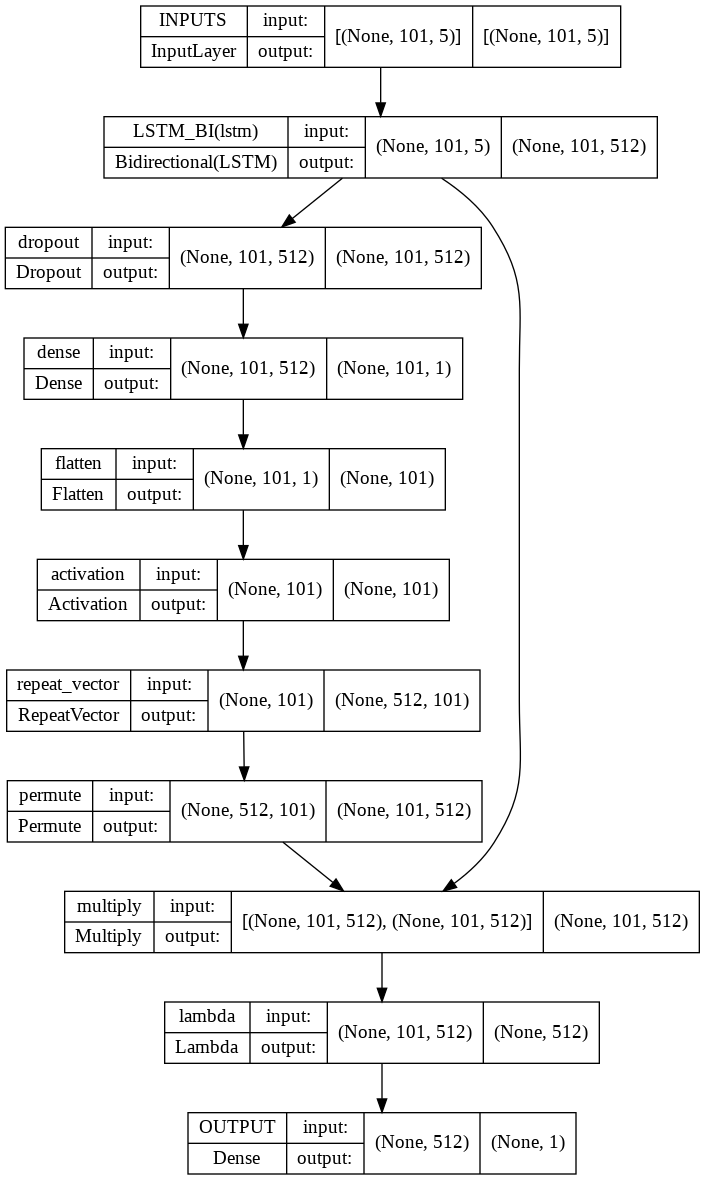

In [16]:
keras.utils.plot_model(model, show_shapes=True)

In [17]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback=EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)

In [20]:
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=[checkpoint,callback],verbose=trace_level)

Epoch 1/20
6712/6712 [==============================] - ETA: 0s - loss: 0.4833 - binary_accuracy: 0.7786
Epoch 1: val_loss improved from inf to 0.39822, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_1CH_ADN.h5
6712/6712 [==============================] - 889s 132ms/step - loss: 0.4833 - binary_accuracy: 0.7786 - val_loss: 0.3982 - val_binary_accuracy: 0.8392
Epoch 2/20
6712/6712 [==============================] - ETA: 0s - loss: 0.3700 - binary_accuracy: 0.8566
Epoch 2: val_loss improved from 0.39822 to 0.31466, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_1CH_ADN.h5
6712/6712 [==============================] - 874s 130ms/step - loss: 0.3700 - binary_accuracy: 0.8566 - val_loss: 0.3147 - val_binary_accuracy: 0.8926
Epoch 3/20
6712/6712 [==============================] - ETA: 0s - loss: 0.2835 - binary_accuracy: 0.9078
Epoch 3: val_loss improved from 0.31466 to 0.26229, saving model to /content/drive/MyDrive/MODELS/best_

In [21]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)    

Trained epochs: 20 of 20


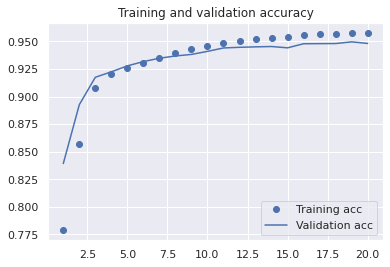

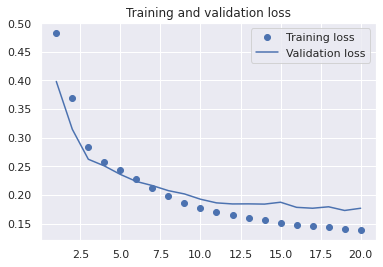

In [22]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We recover the best model saved.

In [23]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

We evaluate the best model on validation data.

In [24]:
#EVALUATE VALIDATION DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=trace_level)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
1438/1438 [==============================] - 142s 99ms/step - loss: 0.1728 - binary_accuracy: 0.9496
Accuracy on validation data: 0.95
Loss on validation data: 0.173


We make predictions on test data, never used during training nor validation

In [25]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=trace_level)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
46030/46030 [==============================] - 504s 11ms/step


In [26]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(46030, 101)
(46030,)
(46030, 1)
(46030, 1)


In [27]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))

MODEL TFM_LSTMBidiAttention_1CH_ADN
---------------------------------
Kappa: 0.894
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     22948
           1       0.92      0.98      0.95     23082

    accuracy                           0.95     46030
   macro avg       0.95      0.95      0.95     46030
weighted avg       0.95      0.95      0.95     46030



Text(80.90000000000006, 0.5, 'Truth Editing')

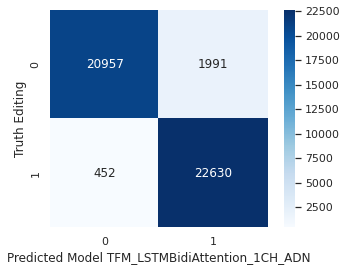

In [28]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
plt.figure()
cm = confusion_matrix(y_test,model_prediction_binary)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,cmap="Blues")
plt.xlabel('Predicted Model '+ model_name)
plt.ylabel('Truth Editing')

AUC: 0.97


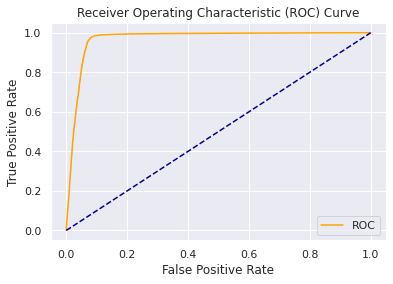

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, model_prediction)
plot_roc_curve(fpr, tpr)
